# PROCESO ETL 
Proceso ETL con datos de migración de extranjeros en Colombia, que podría servir a las entidades del estado para crear estrategias y tomar decisiones oportunas.

### importar las librerias que se van a utilizar

In [30]:
import pandas as pd
from arcgis.gis import GIS
from pathlib import Path
from zipfile import ZipFile
from arcgis.features import FeatureLayer
from arcgis.features import FeatureSet
import numpy as np
from arcgis.features import SpatialDataFrame
import os
import warnings
from arcgis.features import use_proximity
import zipfile

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10

### Los datos fueron tomados del repositorio de datos abiertos

https://www.datos.gov.co/Estad-sticas-Nacionales/Entradas-de-extranjeros-a-Colombia/96sh-4v8d

Se descargaron los archivos csv y se ubicaron en la misma carpeta del proyecto.

Posteriormente se convierten los datos a un DataFrame de pandas.



In [2]:
df = pd.read_csv("Entradas_de_extranjeros_a_Colombia.csv",dtype={'Nueva columna georreferenciada':'str'})
df=df.dropna(axis=0, subset=['Nueva columna georreferenciada'])
df=df[df['Nacionalidad'] == 'Venezuela']
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356)
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794)
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486)
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479)
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675)
...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317)
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013)
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188)
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396)


### Aplicación de funciones lambda
Con el fin de Limpiar las coordenadas, quitando la palabra ‘POINT’ 

In [4]:
lonlat=(df
           .apply(lambda row: row['Nueva columna georreferenciada'],axis=1)
           .apply(lambda word: word.replace('POINT (',''))
           .apply(lambda body: list(body))
           .apply(lambda letters: list(map(lambda letter:letter.replace(")",''),letters)))
           .apply(lambda letters: ''.join(letters))
              )            

df['lat long']=lonlat
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada,lat long
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356),0.81488 -77356
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794),10406342 -75527794
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486),10446304 -75516486
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479),10886686 -74776479
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675),11117206 -74232675
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317),7128047 -73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013),7819 -72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188),7927233 -72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396),836068 -72409396


### Separar latitud y longitud
Tener dos columnas para cada coordenada

In [5]:
latlon_df = df['lat long'].apply(lambda x: pd.Series(x.split(' ')))
df['latt']=latlon_df[0]
df['lonn']=latlon_df[1]
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,Nueva columna georreferenciada,lat long,latt,lonn
907,2012,Enero,Venezuela,297,339,NaN,636,POINT (0.81488 -77356),0.81488 -77356,0.81488,-77356
908,2012,Enero,Venezuela,7,12,NaN,19,POINT (10406342 -75527794),10406342 -75527794,10406342,-75527794
909,2012,Enero,Venezuela,76,133,NaN,209,POINT (10446304 -75516486),10446304 -75516486,10446304,-75516486
910,2012,Enero,Venezuela,55,70,NaN,125,POINT (10886686 -74776479),10886686 -74776479,10886686,-74776479
911,2012,Enero,Venezuela,0,4,NaN,4,POINT (11117206 -74232675),11117206 -74232675,11117206,-74232675
...,...,...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,POINT (7128047 -73181317),7128047 -73181317,7128047,-73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,POINT (7819 -72453013),7819 -72453013,7819,-72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,POINT (7927233 -72508188),7927233 -72508188,7927233,-72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,POINT (836068 -72409396),836068 -72409396,836068,-72409396


### Eliminar la columna lat long
Ya que no se va a utilizar

In [6]:
df=df.drop(['lat long', 'Nueva columna georreferenciada'], axis=1)
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,latt,lonn
907,2012,Enero,Venezuela,297,339,NaN,636,0.81488,-77356
908,2012,Enero,Venezuela,7,12,NaN,19,10406342,-75527794
909,2012,Enero,Venezuela,76,133,NaN,209,10446304,-75516486
910,2012,Enero,Venezuela,55,70,NaN,125,10886686,-74776479
911,2012,Enero,Venezuela,0,4,NaN,4,11117206,-74232675
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,7128047,-73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,7819,-72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,7927233,-72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,836068,-72409396


### Eliminar campos vacios
Pueden generar errores en la ubicación de los puntos

In [7]:
df=df.dropna(axis=0, subset=['latt'])
df=df.dropna(axis=0, subset=['lonn'])
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,latt,lonn
907,2012,Enero,Venezuela,297,339,NaN,636,0.81488,-77356
908,2012,Enero,Venezuela,7,12,NaN,19,10406342,-75527794
909,2012,Enero,Venezuela,76,133,NaN,209,10446304,-75516486
910,2012,Enero,Venezuela,55,70,NaN,125,10886686,-74776479
911,2012,Enero,Venezuela,0,4,NaN,4,11117206,-74232675
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,7128047,-73181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,7819,-72453013
67655,2019,Junio,Venezuela,12,28,NaN,40,7927233,-72508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,836068,-72409396


## Ubicar el punto

In [8]:
long=df['lonn']
df['long']=0
for i in range(1734):
     df['long'].iloc[i]=(long.iloc[i])[0:3]+'.'+(long.iloc[i])[3:]
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,latt,lonn,long
907,2012,Enero,Venezuela,297,339,NaN,636,0.81488,-77356,-77.356
908,2012,Enero,Venezuela,7,12,NaN,19,10406342,-75527794,-75.527794
909,2012,Enero,Venezuela,76,133,NaN,209,10446304,-75516486,-75.516486
910,2012,Enero,Venezuela,55,70,NaN,125,10886686,-74776479,-74.776479
911,2012,Enero,Venezuela,0,4,NaN,4,11117206,-74232675,-74.232675
...,...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,7128047,-73181317,-73.181317
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,7819,-72453013,-72.453013
67655,2019,Junio,Venezuela,12,28,NaN,40,7927233,-72508188,-72.508188
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,836068,-72409396,-72.409396


## ...

In [9]:
lat=df['latt']
df['lat']=0
for i in range(1734):
    if (lat.iloc[i])[0]=='1':
        df['lat'].iloc[i]=(lat.iloc[i])[0:2]+'.'+(lat.iloc[i])[2:]
    elif (lat.iloc[i])[0]=='-':
        df['lat'].iloc[i]=(lat.iloc[i])[1:2]+'.'+(lat.iloc[i])[2:]
    elif (lat.iloc[i])[0]=='0':
        df['lat'].iloc[i]=(lat.iloc[i])[0:1]+'.'+(lat.iloc[i])[2:]
    else:
        df['lat'].iloc[i]=(lat.iloc[i])[0:1]+'.'+(lat.iloc[i])[1:]        


## Eliminar columnas 

In [10]:
df= df.drop(columns=['latt', 'lonn'], axis=1)
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,long,lat
907,2012,Enero,Venezuela,297,339,NaN,636,-77.356,0.81488
908,2012,Enero,Venezuela,7,12,NaN,19,-75.527794,10.406342
909,2012,Enero,Venezuela,76,133,NaN,209,-75.516486,10.446304
910,2012,Enero,Venezuela,55,70,NaN,125,-74.776479,10.886686
911,2012,Enero,Venezuela,0,4,NaN,4,-74.232675,11.117206
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,-73.181317,7.128047
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,-72.453013,7.819
67655,2019,Junio,Venezuela,12,28,NaN,40,-72.508188,7.927233
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,-72.409396,8.36068


## ...

In [11]:
df[['long','lat']] = df[['long','lat']].apply(pd.to_numeric)
df

,Año,Mes,Nacionalidad,Femenino,Masculino,Indefinido,Total,long,lat
907,2012,Enero,Venezuela,297,339,NaN,636,-77.356000,0.814880
908,2012,Enero,Venezuela,7,12,NaN,19,-75.527794,10.406342
909,2012,Enero,Venezuela,76,133,NaN,209,-75.516486,10.446304
910,2012,Enero,Venezuela,55,70,NaN,125,-74.776479,10.886686
911,2012,Enero,Venezuela,0,4,NaN,4,-74.232675,11.117206
...,...,...,...,...,...,...,...,...,...
67653,2019,Junio,Venezuela,9,13,NaN,22,-73.181317,7.128047
67654,2019,Junio,Venezuela,29976,26826,NaN,56802,-72.453013,7.819000
67655,2019,Junio,Venezuela,12,28,NaN,40,-72.508188,7.927233
67656,2019,Junio,Venezuela,1904,1597,NaN,3501,-72.409396,8.360680


In [12]:
df.dtypes

Año               int64
Mes              object
Nacionalidad     object
Femenino          int64
Masculino         int64
Indefinido      float64
Total             int64
long            float64
lat             float64
dtype: object

## CSV

In [13]:
df.to_csv('venezuelafinal2.csv', sep=',', encoding='utf-8')

## Conexión con ArcGis online
por medio de la cuenta de ArcGis Online establecer la conexión 

In [2]:
gis = GIS("https://www.arcgis.com", username="rcmartinb")

Enter password: ········


## Propiedades del archivo csv
Se publica el archivo csv 

In [14]:
venezuela_properties = {
    'title': 'Venezolanos',
    'tags': ['migracion1','migracion2'],
    'type': 'CSV'
}
venezuela_file_location = 'venezuelafinal.csv'
venezuela_csv = gis.content.add(venezuela_properties, data=venezuela_file_location,folder="API Python demos")
venezuela_csv

<Item title:"Venezolanos" type:CSV owner:rcmartinb>

## Publicar

In [15]:
venezuela_feature_layer_item = venezuela_csv.publish()

venezuela_feature_layer_item

<Item title:"Venezolanos" type:Feature Layer Collection owner:rcmartinb>

## Creación y publicación del mapa

In [9]:
m = gis.map()
m.center = [4, -74]           # `[latitude, longitude]`
m.zoom = 5
m

MapView(layout=Layout(height='400px', width='100%'), zoom=5.0)

In [3]:
query = 'title: "Venezolanos*" AND type: "Feature Service"'
search_results = gis.content.search(query=query, max_items=10)
search_results

[<Item title:"Informacion estadistica habitantes venezolanos en la localidad de fontibon_fieldworker" type:Feature Layer Collection owner:jsacevedos_UDFJC>,
 <Item title:"Venezolanos" type:Feature Layer Collection owner:rcmartinb>,
 <Item title:"Venezolanos4" type:Feature Layer Collection owner:rcmartinb>]

In [4]:
Capa = search_results[1]
Capa.url

'https://services.arcgis.com/deQSb0Gn7gDPf3uV/arcgis/rest/services/Venezolanos/FeatureServer'

In [11]:
feature_layers = Capa.layers
Ven_layer = feature_layers[0]
Ven_layer.properties.name

'Venezolanos'

In [12]:
m.add_layer(Ven_layer)
m

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True, zoom=5.0)

In [ ]:
m.add_layer({"type":"FeatureLayer",
                "url":Capa.url,
                "renderer":"HeatmapRenderer",
                "opacity":0.9})
m

### Spatial enabled dataframe

In [13]:
sdf = pd.DataFrame.spatial.from_layer(Ven_layer)
sdf

,Año,Femenino,Indefinido,Masculino,Mes,Nacionalidad,ObjectId,SHAPE,Total,lat,long
0,2013,0.0,None,2.0,Septiembre,Venezuela,1,"{""x"": -8434271.835223416, ""y"": 496188.73597359...",2.0,4.452850,-75.766353
1,2012,297.0,None,339.0,Enero,Venezuela,2,"{""x"": -8611230.529804472, ""y"": 90715.084940370...",636.0,0.814880,-77.356000
2,2013,5626.0,None,6289.0,Septiembre,Venezuela,3,"{""x"": -8253284.488270553, ""y"": 523471.81779439...",11915.0,4.697157,-74.140516
3,2012,7.0,None,12.0,Enero,Venezuela,4,"{""x"": -8407715.568819262, ""y"": 1164850.6920302...",19.0,10.406342,-75.527794
4,2013,3.0,None,15.0,Septiembre,Venezuela,5,"{""x"": -8430934.588208923, ""y"": 536656.48269160...",18.0,4.815189,-75.736374
...,...,...,...,...,...,...,...,...,...,...,...
1729,2017,0.0,None,6.0,Abril,Venezuela,1730,"{""x"": -8322839.911744441, ""y"": 1228810.6785801...",6.0,10.970933,-74.765343
1730,2017,5168.0,None,5629.0,Abril,Venezuela,1731,"{""x"": -8029429.78652505, ""y"": 1272960.40297009...",10797.0,11.360029,-72.129595
1731,2017,1.0,None,1.0,Abril,Venezuela,1732,"{""x"": -9095043.404508019, ""y"": 1412495.5531627...",2.0,12.586200,-81.702165
1732,2017,14.0,None,20.0,Abril,Venezuela,1733,"{""x"": -8519503.714668775, ""y"": 384470.54895057...",34.0,3.451668,-76.532004


In [18]:
sdf1=sdf[sdf['Año']==2018]
sdf1=sdf1[sdf1['Mes']=='Enero']
sdf1=sdf1.drop(columns=['Indefinido'], axis=1)
sdf1

,Año,Femenino,Masculino,Mes,Nacionalidad,ObjectId,SHAPE,Total,lat,long
1167,2018,5.0,3.0,Enero,Venezuela,1168,"{""x"": -7785851.942678761, ""y"": 466974.65828511...",8.0,4.191162,-69.941498
1168,2018,0.0,1.0,Enero,Venezuela,1169,"{""x"": -7785844.48427288, ""y"": 469532.980039683...",1.0,4.214082,-69.941431
1169,2018,24.0,24.0,Enero,Venezuela,1170,"{""x"": -8557846.822716594, ""y"": 36737.861493294...",48.0,0.330020,-76.876446
1170,2018,2.2,2314.0,Enero,Venezuela,1171,"{""x"": -8611230.529804472, ""y"": 90715.084940370...",4514.0,0.814880,-77.356000
1171,2018,0.0,1.0,Enero,Venezuela,1172,"{""x"": -8772274.099425793, ""y"": 2037715.9244116...",1.0,18.001430,-78.802679
...,...,...,...,...,...,...,...,...,...,...
1189,2018,13.0,16.0,Enero,Venezuela,1190,"{""x"": -8146506.944021136, ""y"": 795545.36973172...",29.0,7.128047,-73.181317
1190,2018,33395.0,47879.0,Enero,Venezuela,1191,"{""x"": -8065432.513598431, ""y"": 873121.39069658...",81274.0,7.819000,-72.453013
1191,2018,5.0,15.0,Enero,Venezuela,1192,"{""x"": -8071574.566502949, ""y"": 885284.48624014...",20.0,7.927233,-72.508188
1192,2018,2086.0,2853.0,Enero,Venezuela,1193,"{""x"": -8060577.0913685, ""y"": 934027.2631330751...",4939.0,8.360680,-72.409396


In [20]:
sdf1.spatial.to_featureclass(location=r"export/uno.shp")

'C:\\Users\\rcami\\Documents\\esri\\Api_Python_for_ArcGIS_dev2019\\Ejemplo_con_daos_de_Venezuela\\export\\uno.shp'

In [24]:
shape_zip = zipfile.ZipFile('export/uno.zip', 'w')
 
for folder, subfolders, files in os.walk('export/'):
 
    for file in files:
        shape_zip.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), 'export/'), compress_type = zipfile.ZIP_DEFLATED)
 
shape_zip.close()

In [28]:
shape_properties = {
    'title': 'VENenero2018',
    'tags': 'Venezuela',
    'type': 'Shapefile'
}
shape_file_location = 'export/uno.zip'
VEN201801_shp = gis.content.add(shape_properties, data=shape_file_location,folder="API Python demos")

# You can now visualize the Item object `parks_shp` in rich HTML notation in your notebook.
VEN201801_shp

<Item title:"VENenero2018" type:Shapefile owner:rcmartinb>

In [29]:
VEN201801_item = VEN201801_shp.publish()

# Then visualize the new feature layer
VEN201801_item

<Item title:"VENenero2018" type:Feature Layer Collection owner:rcmartinb>

In [32]:
query = 'title: "2018*" AND type: "Feature Service"'
search_results = gis.content.search(query=query, max_items=10)
search_results

[<Item title:"HurtosBogota2018" type:Feature Layer Collection owner:carozop_UDFJC>,
 <Item title:"homicidios Bogota 2018" type:Feature Layer Collection owner:wrpachonl_UDFJC>,
 <Item title:"VENenero2018" type:Feature Layer Collection owner:rcmartinb>,
 <Item title:"Predios 2018" type:Feature Layer Collection owner:hessuarezp_UDFJC>,
 <Item title:"Predios Cercanos al Humedal El Burro para el Año 2018" type:Feature Layer Collection owner:hessuarezp_UDFJC>]

In [33]:
Capa2 = search_results[2]
feature2_layers = Capa2.layers
Ven_layer2 = feature2_layers[0]
Ven_layer2.properties.name

'uno'

In [34]:
Ven_layer2.properties.fields

[{
   "name": "FID",
   "type": "esriFieldTypeOID",
   "actualType": "int",
   "alias": "FID",
   "sqlType": "sqlTypeInteger",
   "nullable": false,
   "editable": false,
   "domain": null,
   "defaultValue": null
 }, {
   "name": "Id",
   "type": "esriFieldTypeInteger",
   "actualType": "int",
   "alias": "Id",
   "sqlType": "sqlTypeInteger",
   "nullable": true,
   "editable": true,
   "domain": null,
   "defaultValue": null
 }, {
   "name": "A\u00f1o",
   "type": "esriFieldTypeInteger",
   "actualType": "int",
   "alias": "A\u00f1o",
   "sqlType": "sqlTypeInteger",
   "nullable": true,
   "editable": true,
   "domain": null,
   "defaultValue": null
 }, {
   "name": "Femenino",
   "type": "esriFieldTypeDouble",
   "actualType": "float",
   "alias": "Femenino",
   "sqlType": "sqlTypeFloat",
   "nullable": true,
   "editable": true,
   "domain": null,
   "defaultValue": null
 }, {
   "name": "Masculino",
   "type": "esriFieldTypeDouble",
   "actualType": "float",
   "alias": "Masculino

In [39]:
buffer_ven201801 = use_proximity.create_buffers(Ven_layer2,
                                                     field='Total',
                                                     units='meters',
                                                     output_name='buffers_total')

In [40]:
m2 = gis.map()
m2.center = [4, -74]           # `[latitude, longitude]`
m2.zoom = 5
m2.add_layer(buffer_ven201801)
m2

MapView(layout=Layout(height='400px', width='100%'), zoom=5.0)

# Análisis Descriptivo
##### Con los datos limpios y publicados en ArcGis online, tambien podemos hacer es realizar un análisis descriptivo que permita entender parametros determinantes para la toma de decisiones

In [27]:
import matplotlib.pyplot as plt

Gráfica de cantidad agrupado por años

In [28]:
df3=sdf[['Año','Total']]
df3=df3.groupby(['Año'])['Total'].sum()
df3

Año
2012     229347.15
2013     239434.93
2014     225129.54
2015     218044.12
2016     289977.79
2017     614705.64
2018    1233152.79
2019     529175.04
Name: Total, dtype: float64

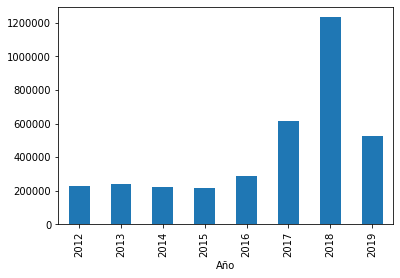

In [29]:
df3.plot(kind='bar')

Gráfica agrupado por género

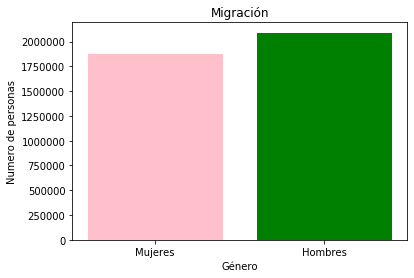

In [30]:
x = ["Mujeres","Hombres"]
y = [df['Femenino'].sum(),df['Masculino'].sum()]

plt.bar(x, y, color=['pink','green'])

plt.title('Migración')
plt.xlabel('Género')
plt.ylabel('Numero de personas')
#plt.savefig('ScatterPlot_03.png')
plt.show()

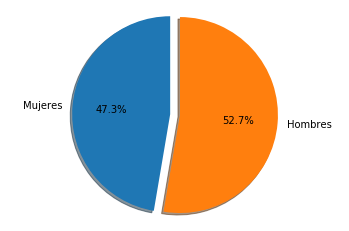

In [31]:
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Unificar gráficos

In [32]:
dfx=pd.DataFrame(columns=['Año','Femenino'])

dfy=df.groupby('Año').sum()
dfy= dfy.drop(columns=['Indefinido','long', 'lat'], axis=1)
dfy

,Femenino,Masculino,Total
Año,,,
2012,113984,137491,251475
2013,117070,144273,261343
2014,107787,137862,245649
2015,124369,148740,273109
2016,148830,174904,323734
2017,320487,377775,698262
2018,658110,701706,1359816
2019,286516,266675,553191


TypeError: only size-1 arrays can be converted to Python scalars

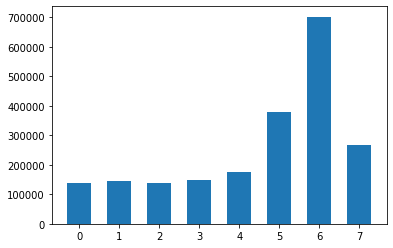

In [33]:
import numpy as np

N = 8
hombres = dfy['Masculino']
mujeres = dfy['Femenino']
hombStd = (2, 3, 4, 1, 2,2,2,2)
mujStd = (3, 5, 2, 3, 3,2,2,2)
ind = np.arange(N)   
width = 0.6       

p1 = plt.bar(ind, hombres, width, yerr=hombStd)
p2 = plt.bar(ind, mujeres, width,
             bottom=hombres, yerr=mujStd)

plt.ylabel('Número de personas')
plt.xlabel('Año')
plt.title('Número de Venezonlanos que llegan a Colombia')
plt.xticks(ind, (df3.index))

plt.legend((p1[0], p2[0]), ('Hombres', 'Mujeres'))

plt.show()

#### Agrupado por mes

In [34]:
df4=sdf[['Mes','Total']]
df4=df4.groupby(['Mes'])['Total'].sum()
df4

Mes
Abril         346508.20
Agosto        293620.17
Diciembre     333129.70
Enero         334038.20
Febrero       285602.47
                ...    
Marzo         288513.42
Mayo          331510.45
Noviembre     292797.14
Octubre       218793.90
Septiembre    270704.45
Name: Total, Length: 12, dtype: float64

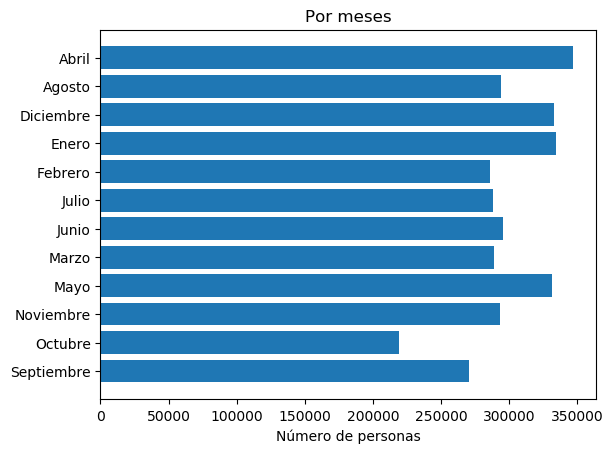

In [35]:
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

meses = df4.index
y_pos = np.arange(len(meses))
performance = df4

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(meses)
ax.invert_yaxis()
ax.set_xlabel('Número de personas')
ax.set_title('Por meses')

plt.show()

### Datos importantes
Como máximo, mínimo, mediana, entre otros datos estadísticos importantes

In [36]:
dfy.describe()

,Femenino,Masculino,Total
count,8.000000,8.000000,8.000000e+00
mean,234644.125000,261178.250000,4.958224e+05
std,190256.584618,197103.160796,3.867902e+05
min,107787.000000,137491.000000,2.456490e+05
25%,116298.500000,142670.250000,2.588760e+05
50%,136599.500000,161822.000000,2.984215e+05
75%,295008.750000,294450.000000,5.894588e+05
max,658110.000000,701706.000000,1.359816e+06


In [23]:
df["Total"].max()

82609

In [24]:
df["Total"].min()

1

In [25]:
df["Total"].mean()

2287.531141868512